# 定义取数获得的Graph

In [1]:
TGraph* getdedx(string filename, int A){

    ifstream in(filename);

    auto *g = new TGraph;
    string s;
    double e, dedx;

    getline(in, s);
    int i = 0;

    while(!in.eof()){

        in >> e >> dedx;
        getline(in, s);
        if(in.eof()) break;//避免最后一个重复读取

        g->SetPoint(i++, e*A, dedx);//将数据填入创建的Graph，这里的de/dx单位为Mev/微米
    }

    in.close();
    return g;
}

# 封装计算能损本领的函数

In [2]:
double Z_1_8_dedx(string element, int A, double E){//设置输入量，element为元素名称
    
    string a = "./data_new/";
    string b = "_si.txt";
    string c = a + element + b ;
    double dedx;  

    TGraph *z1 = getdedx(c, A);
    dedx = z1->Eval(E, 0, "S");
    

    
    return dedx;//返回能量损失本领

}

# 封装计算粒子射程的函数
<font size = 4>首先对返回E-x曲线和x-E曲线的Graph进行定义，然后利用这个Graph对粒子入射的距离进行计算

In [3]:
TGraph *ex_gra(string element, int A, int choose){//设置输入量，其中choose的作用是标记返回的曲线类型

    auto *graph1 = new TGraph;
    auto *graph2 = new TGraph;
    int n = 1e8;
    double E_init = 1000., x = 0.;//设置能量初值，和位置初值

    for (int i = 0; i < n; i++){

        E_init = E_init - 100*Z_1_8_dedx(element, A, E_init);//通过迭代求出能量为0时的射程
        x = x + 0.1;
        
        //将数据填入Graph
        graph1->SetPoint(i, E_init, x);
        graph2->SetPoint(i, x, E_init);

        if (E_init < 0) break;
    }

    if (choose == 0) return graph1;//如果choose选择0，则返回E-x曲线
    else if (choose == 1) return graph2;//如果choose选择1，则返回x-E曲线
    else {
        return graph1;
        cout << "plz enter choose 1 or 0" << endl;
    }
}

In [4]:
double range_fun(string element, int A, double E, TGraph *g_range_fun) {
    
    //if(Z > 8 || Z < 1 || Z > A) cout << "Plz enter right Z and A" << endl;

    TGraph *ele = g_range_fun;
   
    return (ele->Eval(0, 0, "S"))-(ele->Eval(E, 0, "S"));//通过E=0时对应的x值减去输入E对应的x值即为射程

}

# 封装能损计算函数
<font size = 4>由上面的函数可以得到E-x和x-E曲线，由E-x曲线可以求得x0,用x0加上探测器厚度dx可以得到x'。再用x-E曲线可以求得x'对应的E'。E-E'即为能量的损失。如果射程小于探测器厚度，那么全部能量都损失掉了。

In [5]:
double de_thick(string element, int A, double E, double thickness, TGraph *g1_de_thick, TGraph *g2_de_thick){
    
    double e_loss;

    if (range_fun(element, A, E, g1_de_thick) <= thickness ) {//如果射程小于厚度则损失所有能量

        e_loss = E;
        //cout << "Lose all energy" << endl;
    }

    else {

        TGraph *e_x_gra = g1_de_thick;//E-x曲线
        TGraph *x_e_gra = g2_de_thick;//x-E曲线

        double x0, x_prime, E_prime;

        x0 = e_x_gra->Eval(E, 0, "S");
        E_prime = x_e_gra->Eval(x0+thickness, 0, "S");//求E'

        e_loss = E - E_prime;//能量损失
    }

    return e_loss;

}

# 定义望远镜法用的函数
<font size = 4>该函数可以产生root文件并绘制图像，产生root文件比较费时所以运行该文本时请注释掉！！！

In [6]:
void new_tele(){
    /*该注释段即为root文件产生的方法因为比较消耗资源所有注释掉，相应的root文件已经上传
    double de1, de2, de3;
    TRandom3 *ran = new TRandom3(0);
    TFile *file = new TFile("telescope.root","RECREATE"); //产生新的root file以及tree
    TTree *tree = new TTree("tree", "Ran_Events");

    tree->Branch("de1", &de1, "de1/D");
    tree->Branch("de2", &de2, "de2/D");
    tree->Branch("de3", &de3, "de3/D");

    for(int j = 0; j < 1000; j ++){

        int Z = ceil(ran->Uniform(0, 8)); //随机产生Z值
        string res;
        stringstream ss;
        ss << Z, ss >> res;  //将Z转化为字符串
        
        int A = 2*Z + ceil(ran->Uniform(-2, 2)); //随机产生A值

        auto *e_x_he = new TGraph;
        e_x_he->Clear();
        e_x_he = ex_gra(res, A, 0);
        auto *x_e_he = new TGraph;
        x_e_he->Clear();
        x_e_he = ex_gra(res, A, 1);

        for(int i =0; i < 1000; i++){//计算三个能损
            
            double E1_he = 35*A*ran->Rndm();
            de1 = de_thick(res, A, E1_he, 1, e_x_he, x_e_he);
        
            double E2_he = E1_he - de1;
            de2 = de_thick(res, A, E2_he, 0.5, e_x_he, x_e_he);
        
            double E3_he = E2_he - de2;
            de3 = de_thick(res, A, E3_he, 1, e_x_he, x_e_he);

            tree->Fill();//写入tree
    }

    }

    tree->Write();
    file->Close();
*/
    TFile *new_f = new TFile("telescope.root", "READ");//读入产生好的root文件
    TTree *new_tree = (TTree*)new_f->Get("tree");
    
    TCanvas *c = new TCanvas("c", " ", 800, 600);
    c->Divide(3,1);
    
    c->cd(1);
    new_tree->Draw("de1:de2>>h1(500,0,250,1000,0,500)", "de2 > 0", "colz");//绘制一二两块探测器能损对比
    c->cd(2);
    new_tree->Draw("de2:de3>>h2(500,0,250,500,0,250)", "de3 > 0", "colz");//绘制二三两块探测器能损对比
    c->cd(3);
    new_tree->Draw("de1:(de1+de2+de3)>>h3(500,0,600,500,0,500)", "de2>0&&de3>0", "colz");//绘制第一块探测器与总能损对比
    
    c->Draw();
}


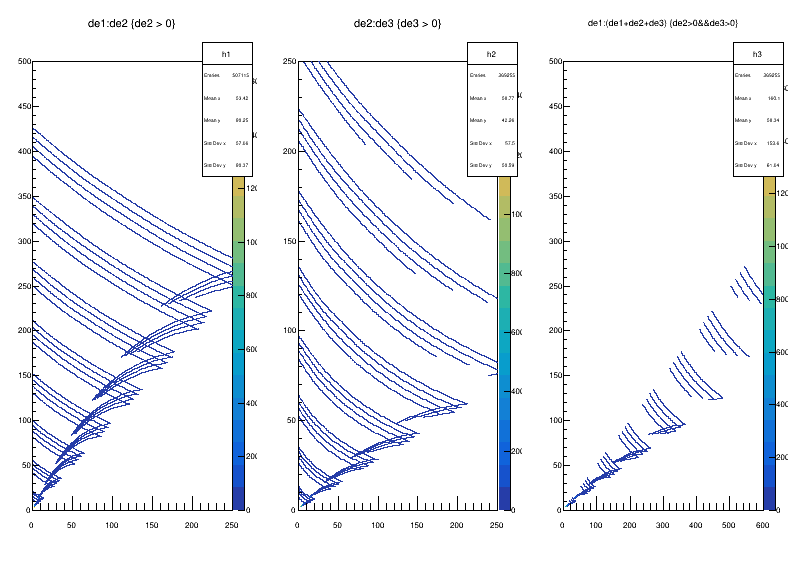

In [7]:
new_tele();

<font size = 4> 可以看到很明显的对应于不同元素以及不同同位素的曲线，可以鉴别出粒子种类。另外直接使用root文件跑大大节省代码运行时间。